# TP 5 : Advantage Actor Critic

Ce TP est disponible dans google colab [ici](https://colab.research.google.com/drive/1RJOAo46rImtqTrSEOGvCiC3-_47vbb2M?usp=sharing)
ou téléchargeable [ici](cedric.cnam.fr/~rambourc/RCP211_RL_TP5.ipynb)

[Mnih, Volodymyr, et al. "Asynchronous methods for deep reinforcement learning." International conference on machine learning. 2016.](http://proceedings.mlr.press/v48/mniha16.pdf)

## Actor-Critic

*Advantage Actor Critic* est une méthode optimisation de la politique populaire en RL. Cette approche consiste à maximiser le retour moyen en favorisant les probailités liées aux actions donnant le plus de récompenses. Si $\pi_\theta$ consiste en une politique paramètrée par $\theta$, le gradient de notre fonction objectif  $\mathcal{J}(\pi_\theta)$ s'écrit

$$ \nabla_\theta \mathcal{J}(\pi_\theta) = \underset{\tau\sim\pi_\theta}{\mathbb{E}}\left[ \sum^T_{t=0} \nabla_\theta \log \pi_\theta(a_t|s_t)A^{\pi_\theta}(s_t, a_t) \right],$$

avec $\tau$ la trajectoire et $A^{\pi_\theta}$ la fonction avantage. L'approche policy gradient consiste ) mettre à jour les paramètre de $\pi$ par montée de gradient :

$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta \mathcal{J}(\pi_{\theta_k}),$$

avec $\alpha$ le learning rate. L'agent est entraîné de façon *on-policy* c'est à dire que les paramètres sont mis à jour par la politique courrante.

### Advantage Function

La fonction avantage $A$ permet de réduire la variance de la fonction de valeur et est défini comme suit

$$ A(s,a) = Q(s,a) - V(s) $$

On peut remplacer $Q$ avec $r+\gamma V(s')$ et estimer $A$ de la façon suivante:

$$ A(s,a) = r + \gamma V(s') - V(s) $$


## Maximization Entropy

L'entropie est une mesure d'incertitude. À des actions avec une probabilité uniforme correspond une entropie maximale tandis que l'entropie est nulle lorsque toute la masse est concentrée sur une action. L'entropie $H$ par rapport à la probabilité $p$ sur les action est

$$ H(P) = - \sum_a p(a) \log p(a) $$


### import module and seed

In [ ]:
import random
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Modèle

Nous allons utiliser deux modèles séparés pour l'acteur et le critique.

Acteur :

* Une couche linéaire cachée de taille *in_dim*x*128*

* ReLU

* Deux sortie correspondant à la moyenne de la densité et à son écart type correspondant chacune à une couche linéaire de taille *128*x*out_dim*

* Activation pour la moyenne : tanh

* Activation pour écart type : softplus puis exponentielle


Critique :

* Une couche linéaire cachée de taille *in_dim*x*128*

* Une couche linéaire de taille 128x1 donnant la valeur

### Coding Task :

Compléter les modèles suivant pour l'acteur et le critique

In [ ]:
def initialize_uniformly(layer: nn.Linear, init_w: float = 3e-3):
    """Initialize the weights and bias in [-init_w, init_w]."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)


class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = ...
        self.mu_layer = ...
        self.log_std_layer = ...

        initialize_uniformly(self.mu_layer)
        initialize_uniformly(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = ..

        mu = ...
        log_std = ...
        std = ...

        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist

class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = ...
        self.out = ...

        initialize_uniformly(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = ...
        value = ...

        return value

## A2C Agent

La classe A2CAgent permet de sélectioner une action, avancer dans l'environnement, mettre à jour le modèle, l'entrâiner et le tester.


| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |




### Coding Task



Compléter la méthode `update model` :

1. Estimer la valeur grâce au critique

2. Calculer la target du crtique avec une approche TD

3. Minimiser la loss du critique et mettre à jour la critique

4. Caculer l'avantage

5. caculer la loss pour le modèle gérant la politique.  
NB: Ne pas oublier la régularisation donnée par l'entropie

6. mettre à jour la politique

In [ ]:
class A2CAgent:
    """A2CAgent interacting with environment.

    Atribute:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(self, env: gym.Env, gamma: float, entropy_weight: float):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # transition (state, log_prob, next_state, reward, done)
        self.transition: list = list()

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            self.transition = [state, log_prob]

        return selected_action.clamp(-2.0, 2.0).cpu().detach().numpy()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _, _ = self.env.step(action)

        if not self.is_test:
            self.transition.extend([next_state, reward, done])

        return next_state, reward, done

    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        state, log_prob, next_state, reward, done = self.transition

        ############ Votre code ici #####################
        #### Critique : estimation et mise à jour ######
        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise


        # update value


        # advantage = Q_t - V(s_t)


        # Policy loss :  sum(-advantage * log(politique) )


        # update policy


        #########################################################

        return policy_loss.item(), value_loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset()[0]
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = env.reset()[0]
                scores.append(score)
                score = 0

            # plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)
        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True

        state = self.env.reset()[0]
        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        return frames

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment

L'environnement ici est continue est consiste en un pendule inversé.

In [ ]:
env_id = "Pendulum-v1"
env = gym.make(env_id,render_mode="rgb_array")

Pour initialiser l'agent nous pouvons utiliser le code suivant

In [ ]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2

agent = A2CAgent(env, gamma, entropy_weight)

cuda


Enfin l'entrainement se fait avec la méthode train

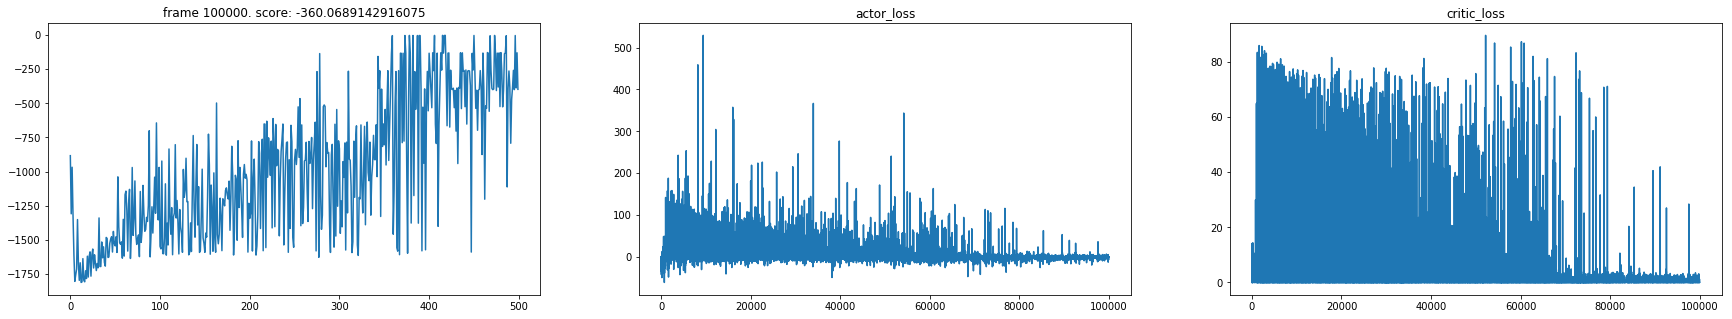

In [ ]:
agent.train(num_frames)

## Test

In [ ]:
from gym.wrappers import RecordVideo

env = RecordVideo(agent.env,video_folder = './video')
frames = agent.test()

score:  -135.17415452820998


## Render

In [ ]:
! pip install JSAnimation


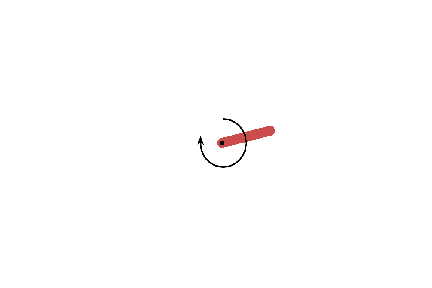
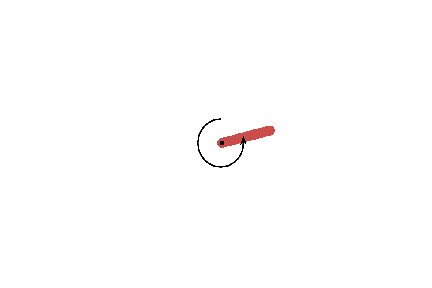
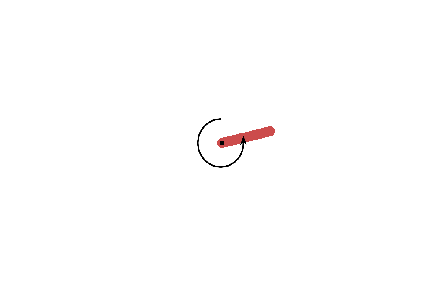
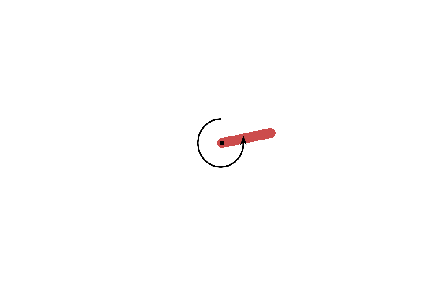
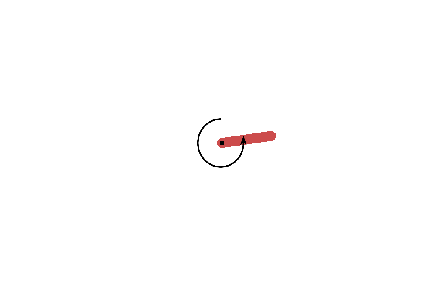
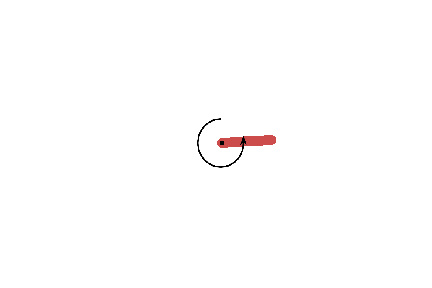
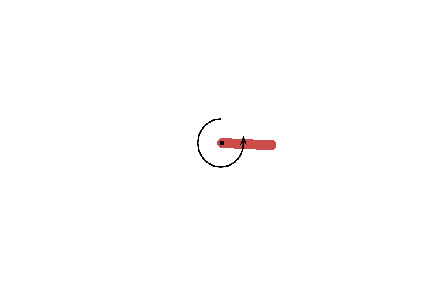
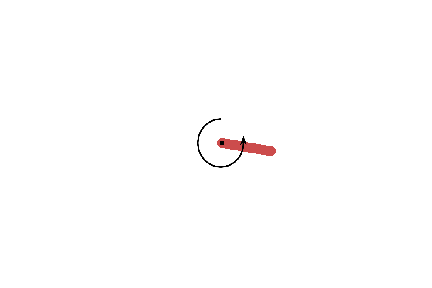
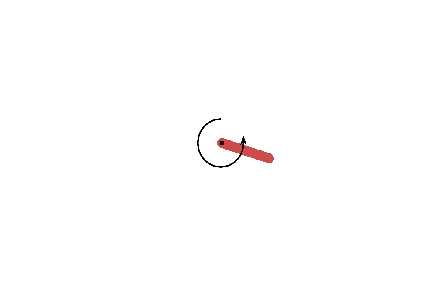
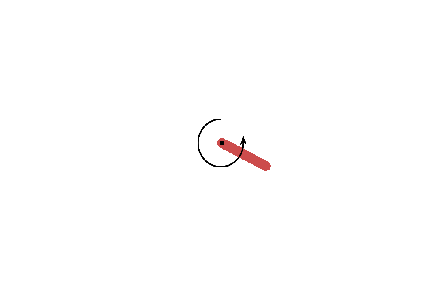
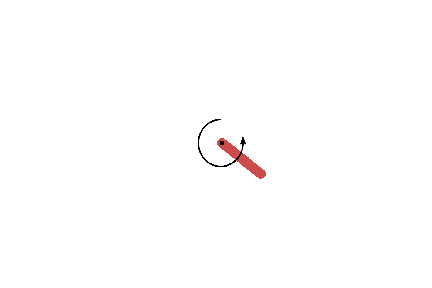
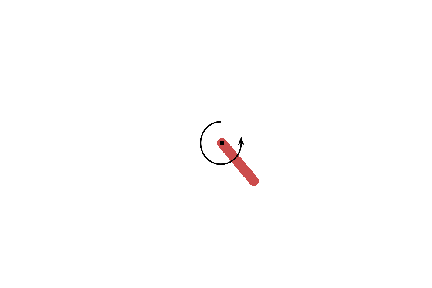
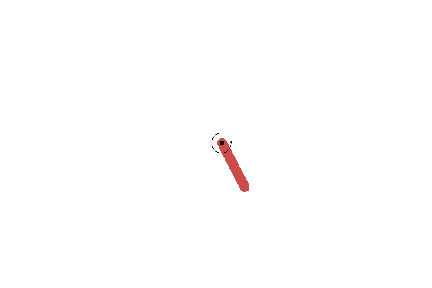
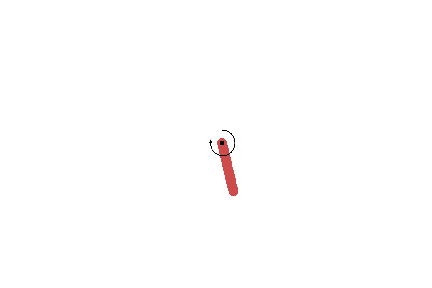
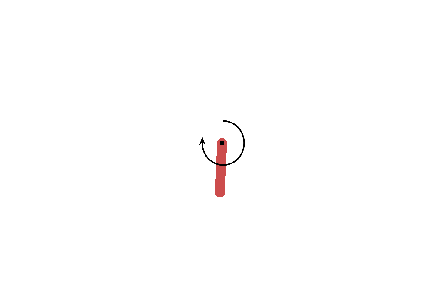
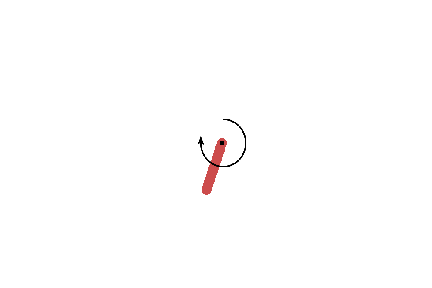
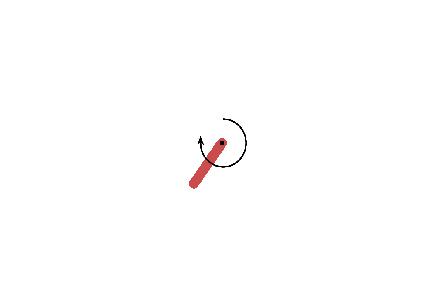
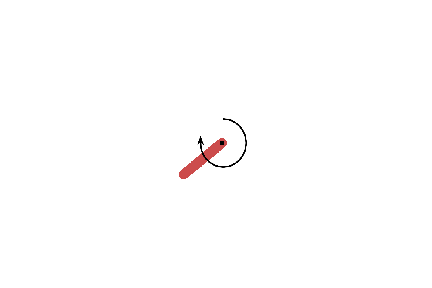
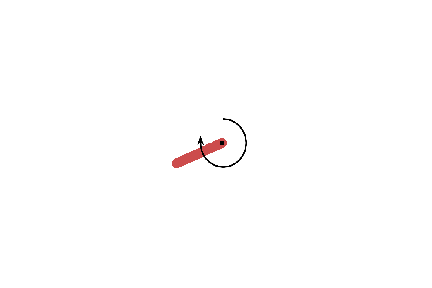
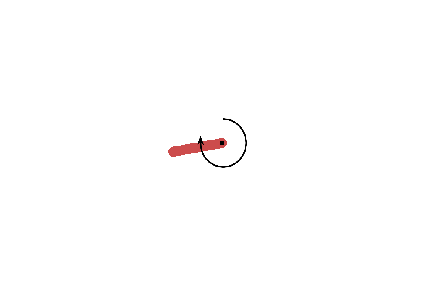
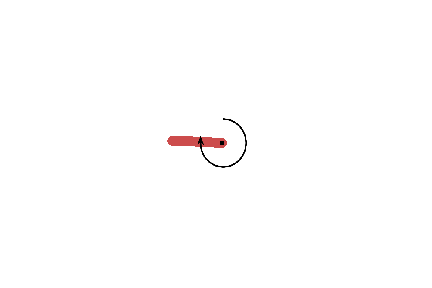
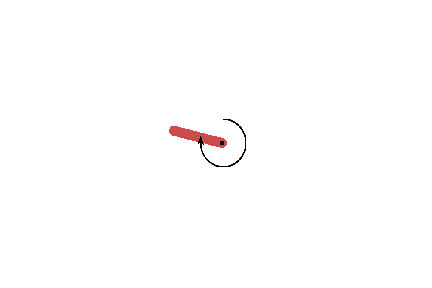
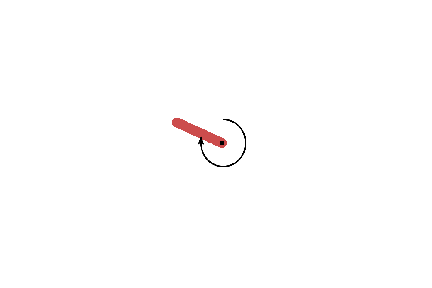
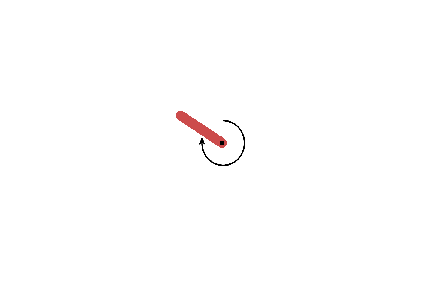
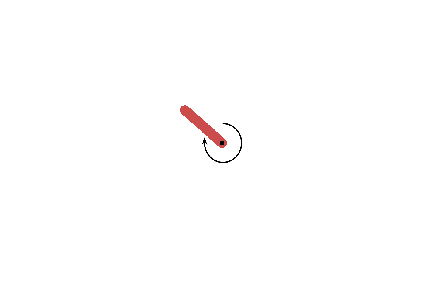
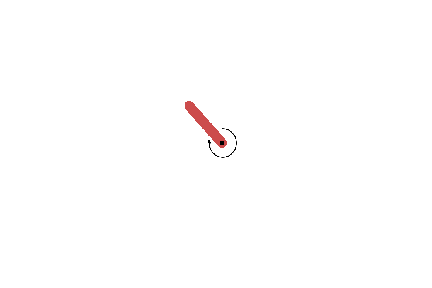
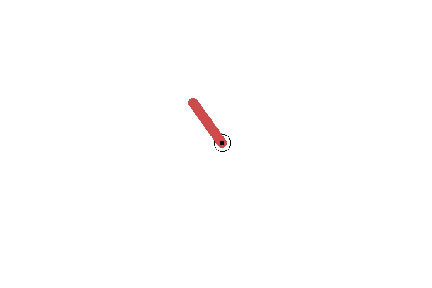
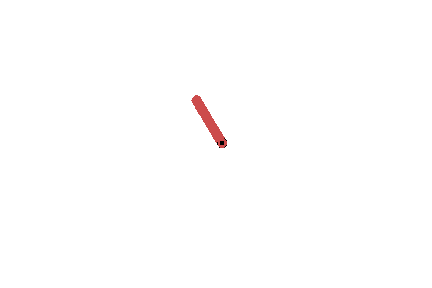
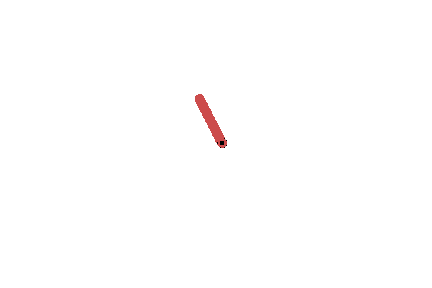
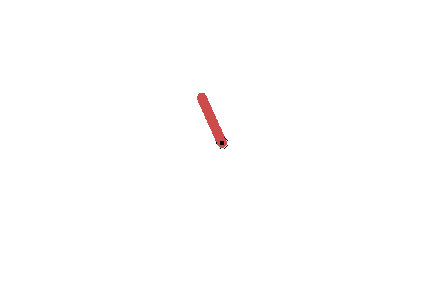
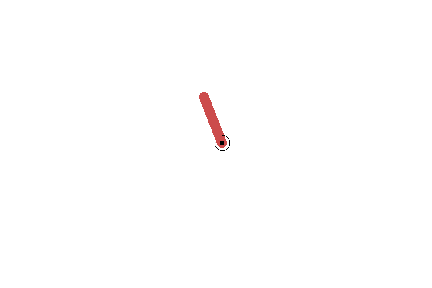
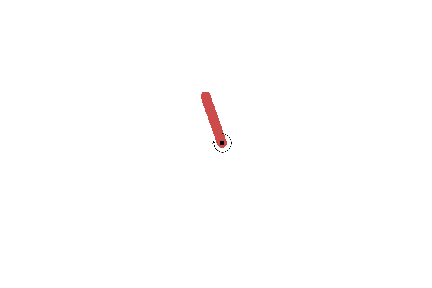
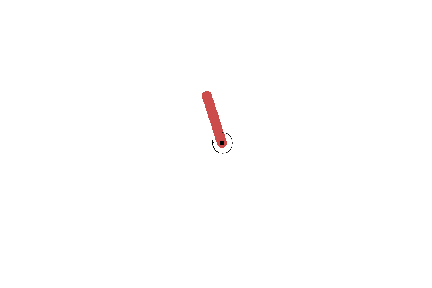
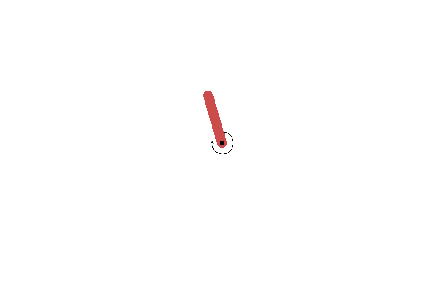
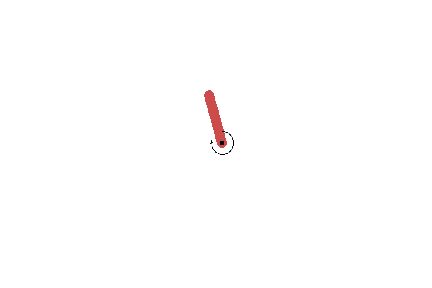
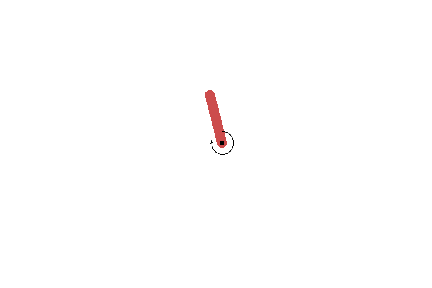
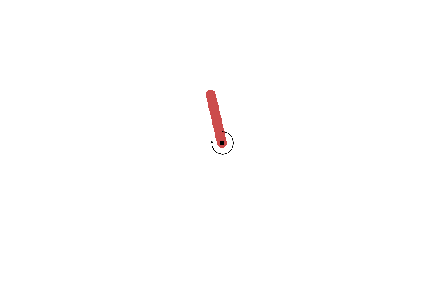
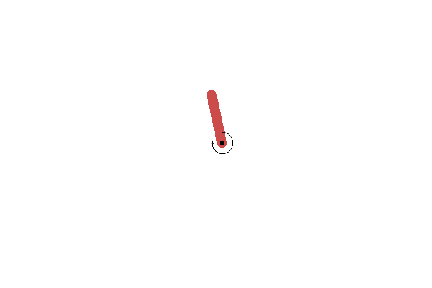
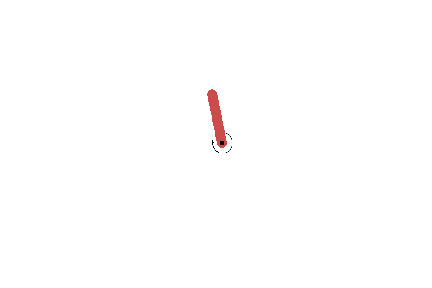
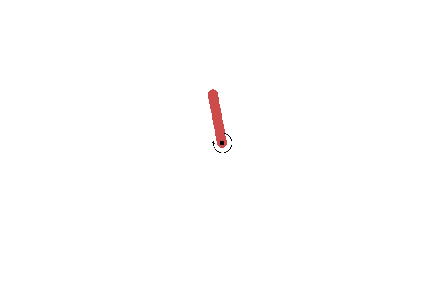
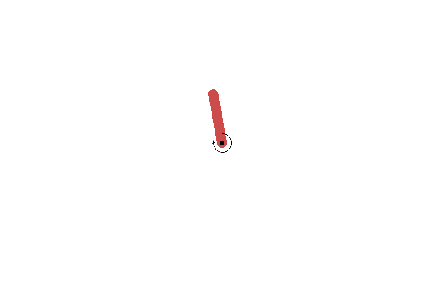
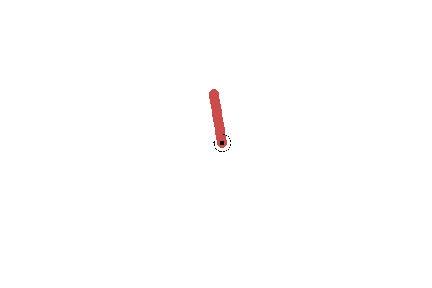
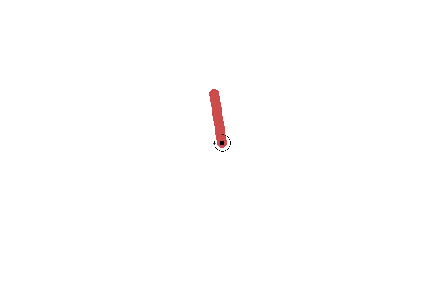
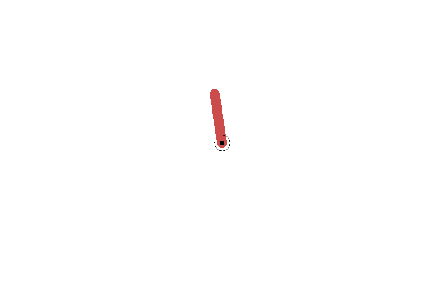
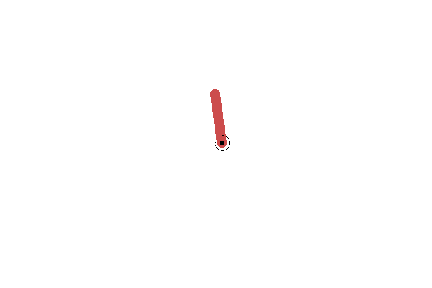
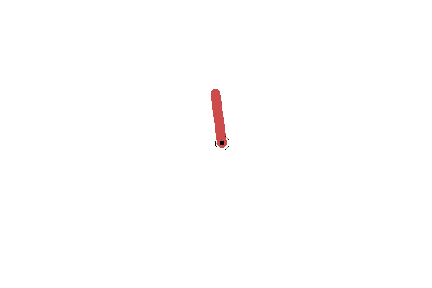
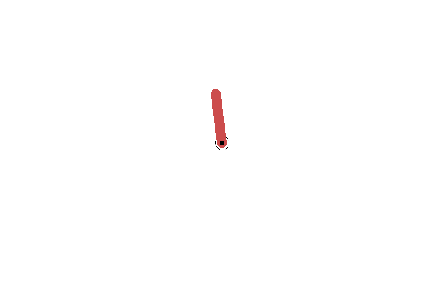
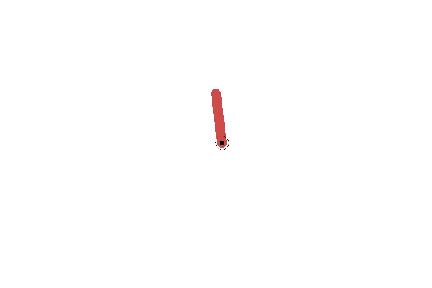
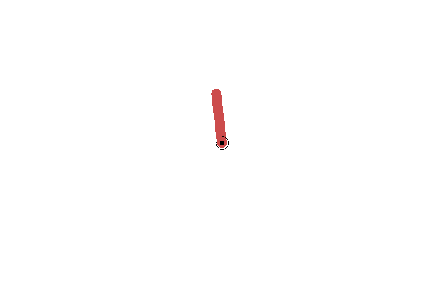
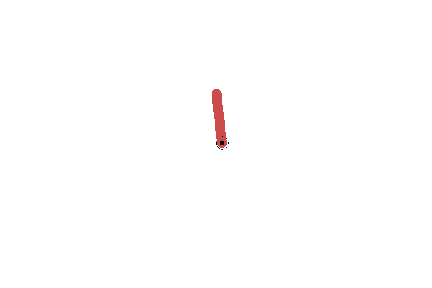
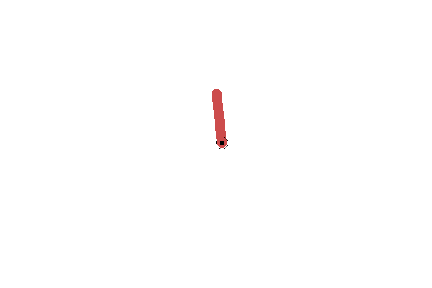
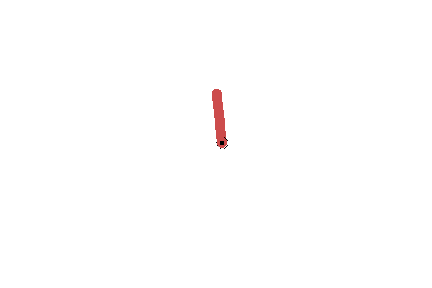
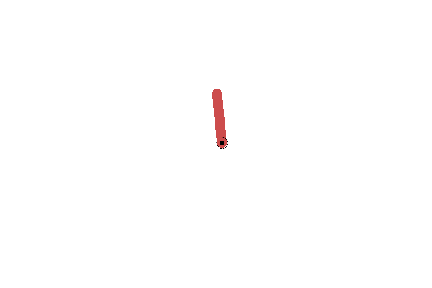
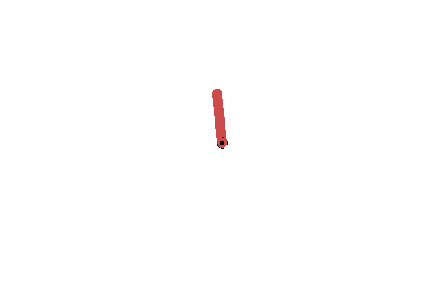
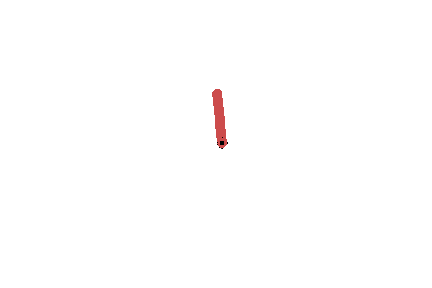
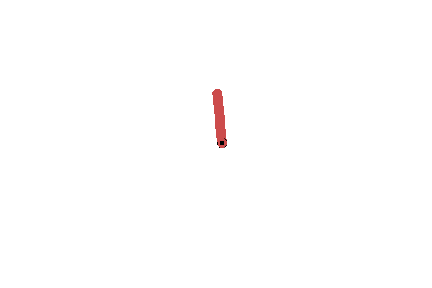
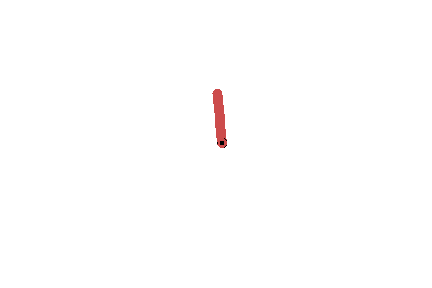
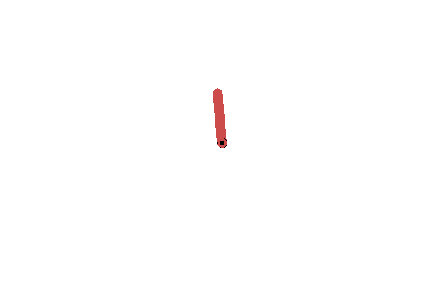
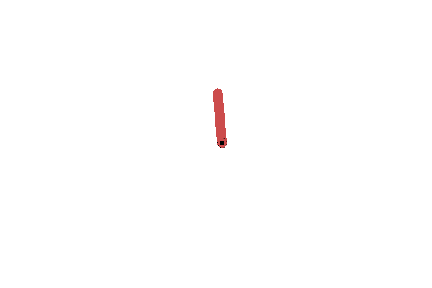
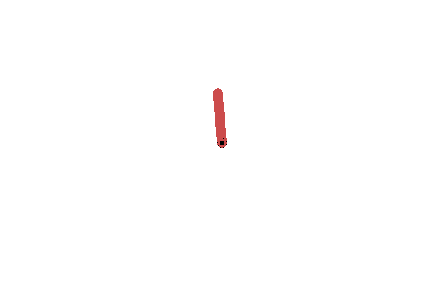
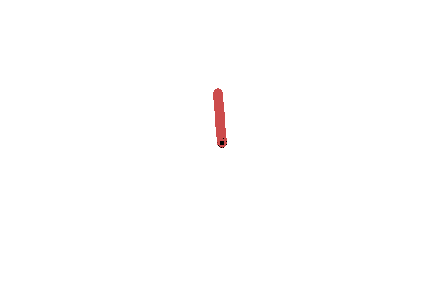
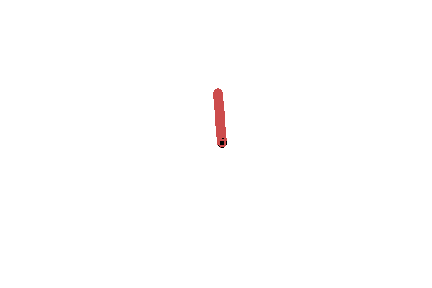
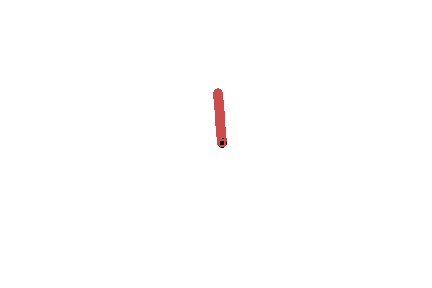
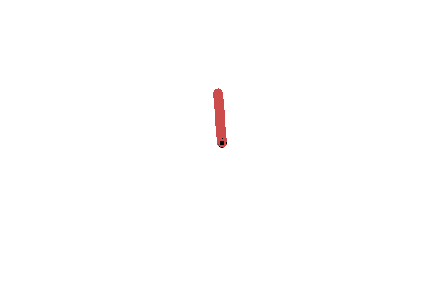
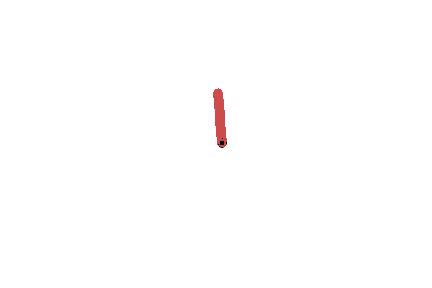
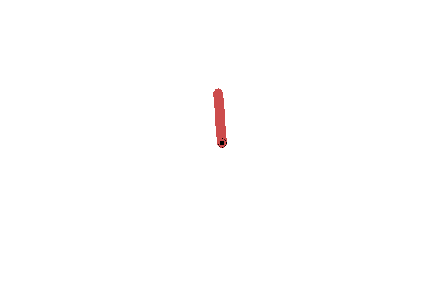
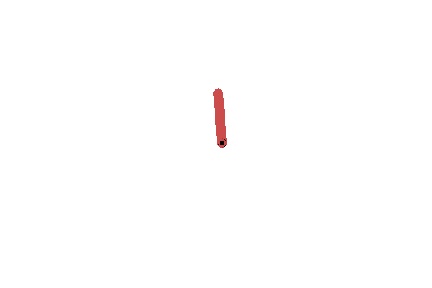
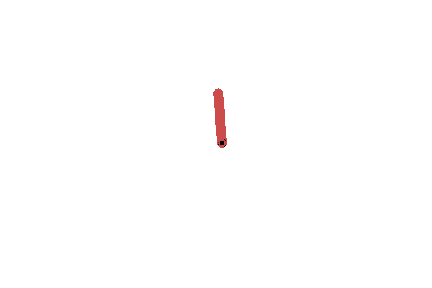
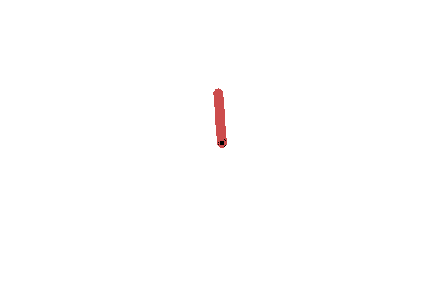
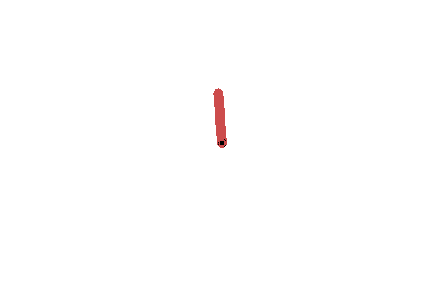
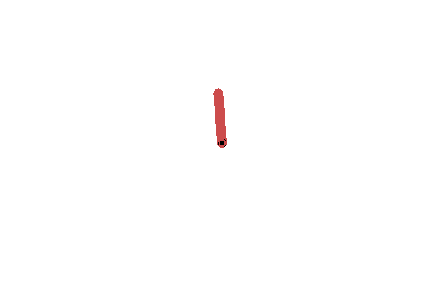
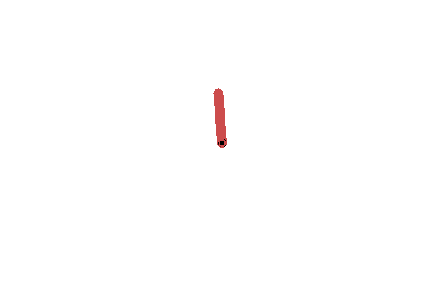
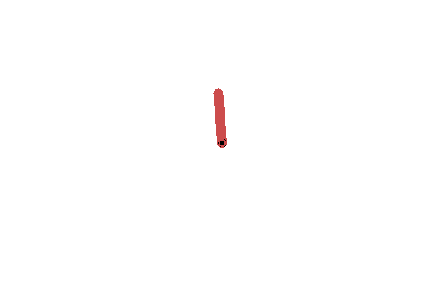
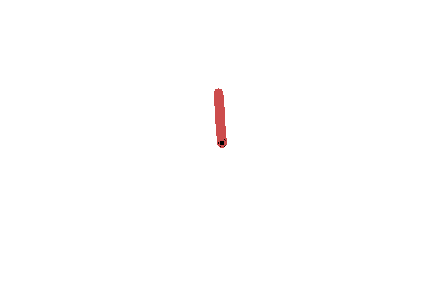
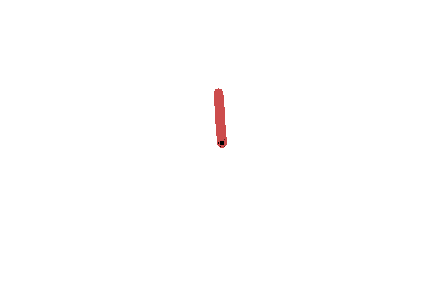
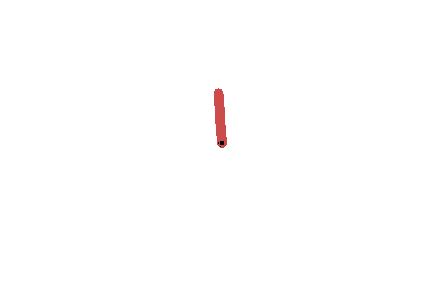
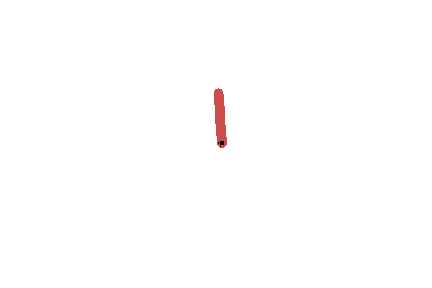
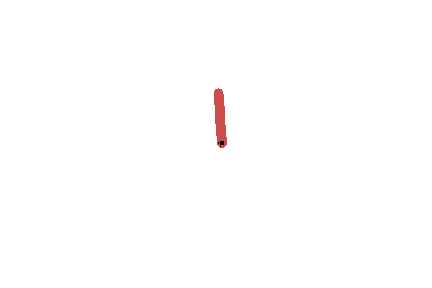
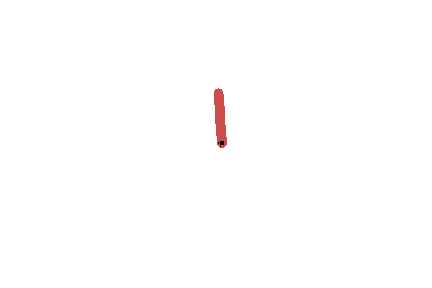
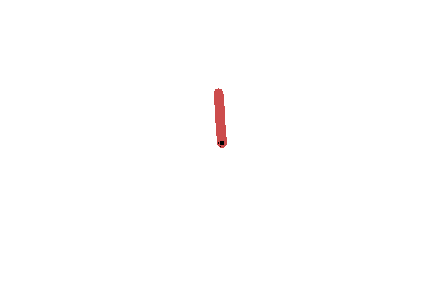
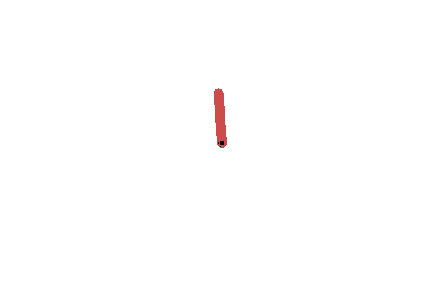
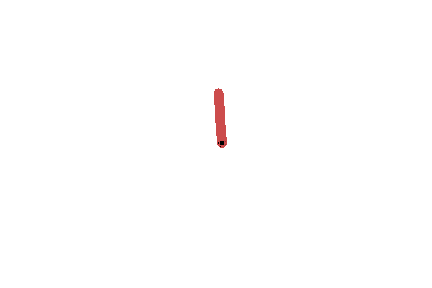
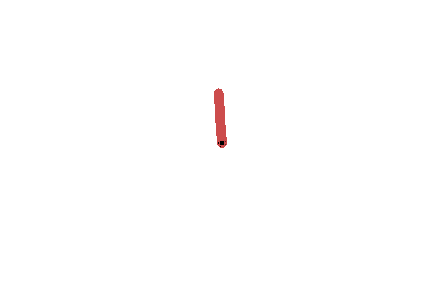
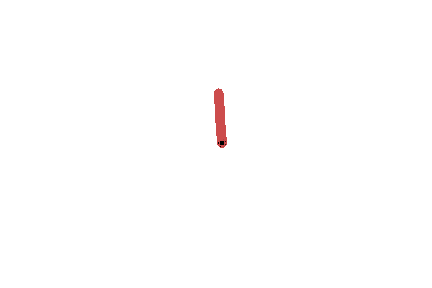
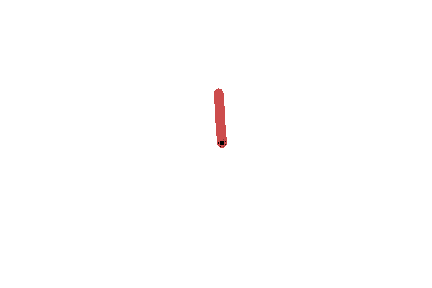
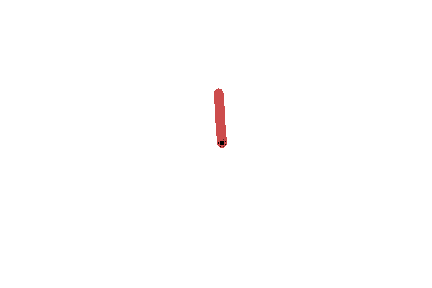
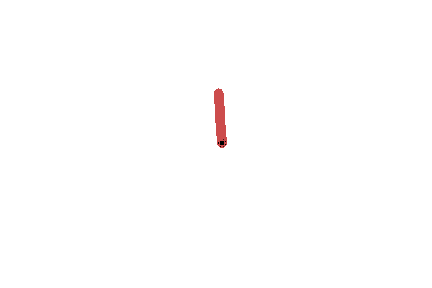
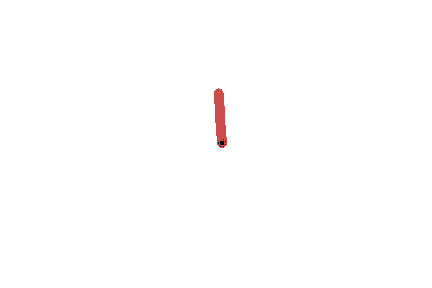
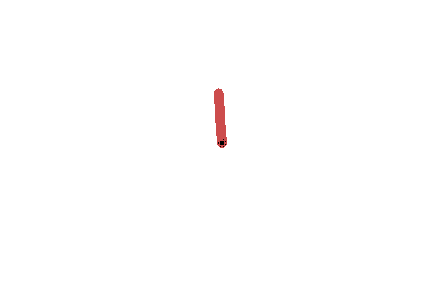
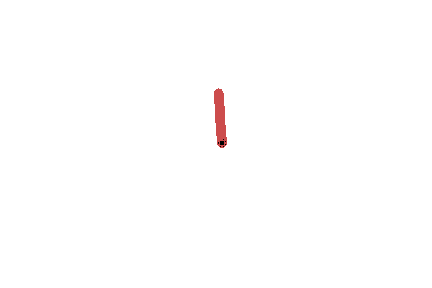
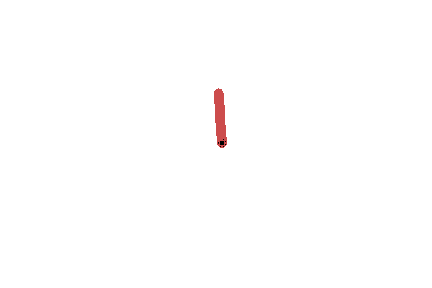
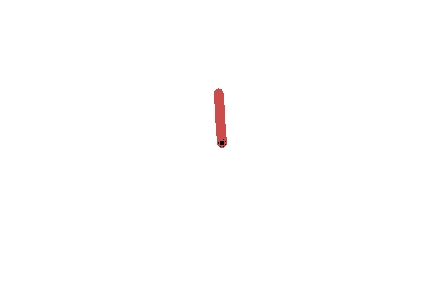
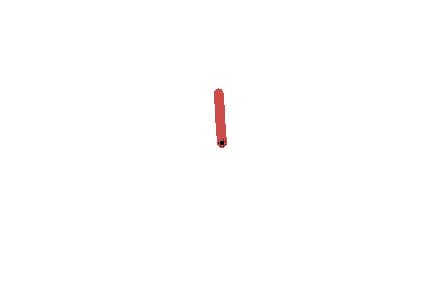
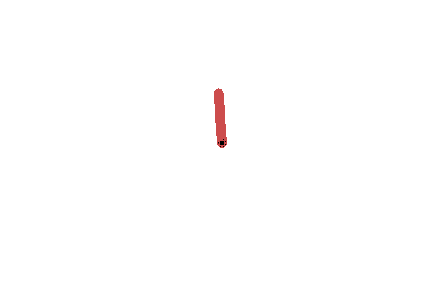
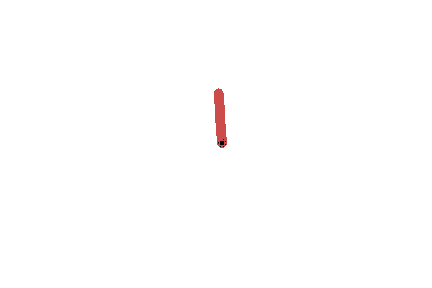
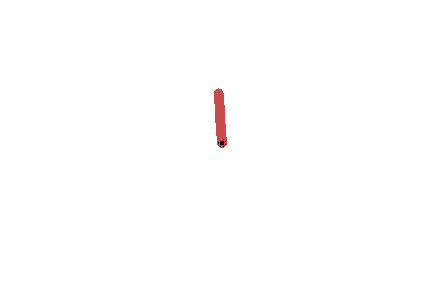
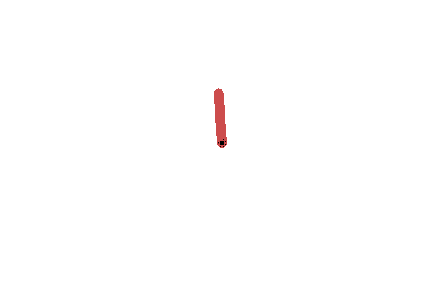
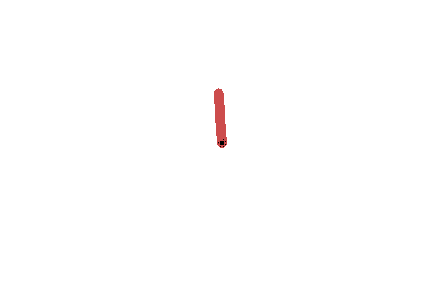
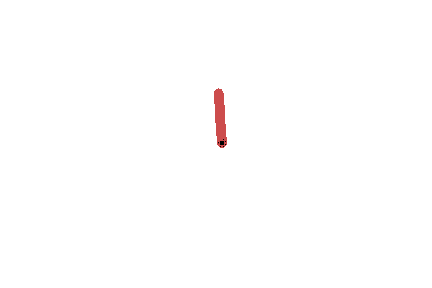
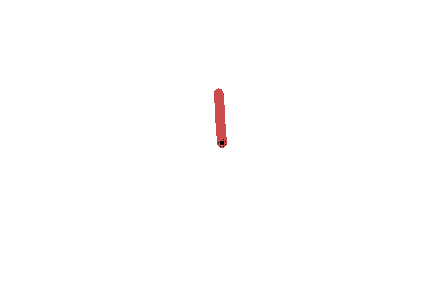
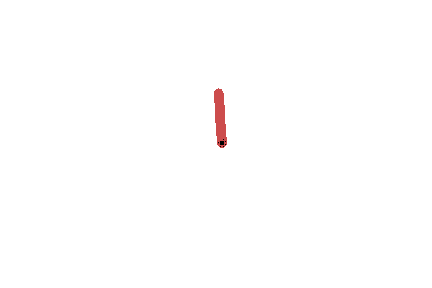
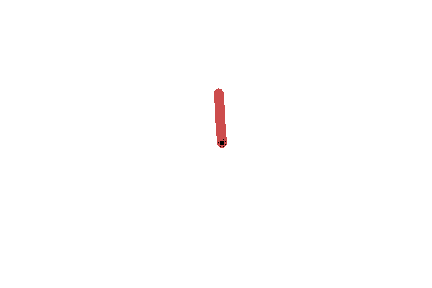
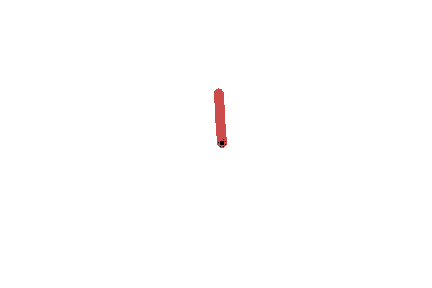
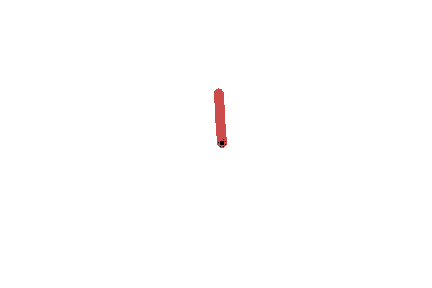
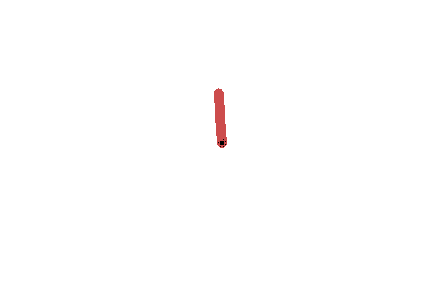
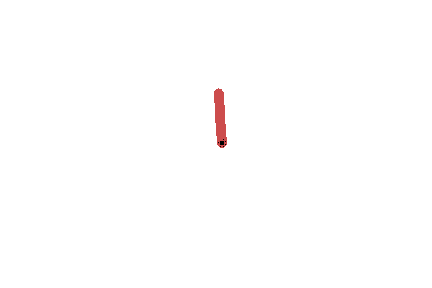
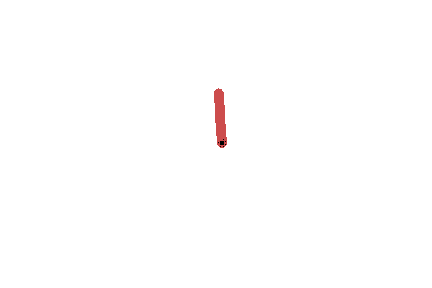
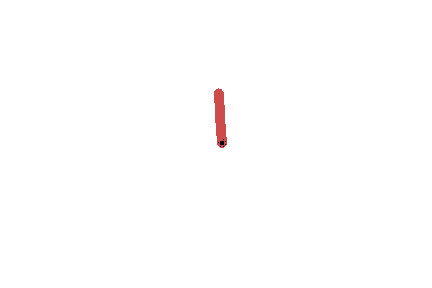
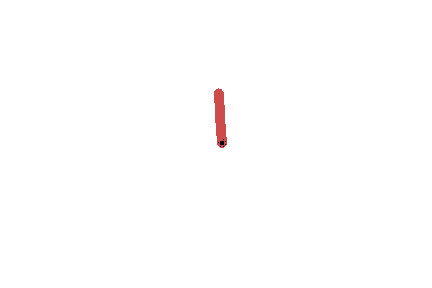
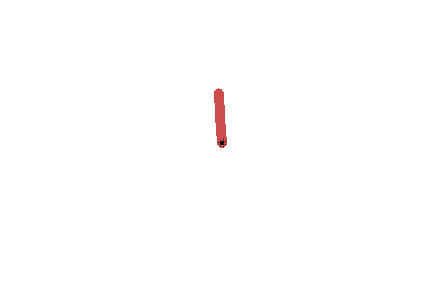
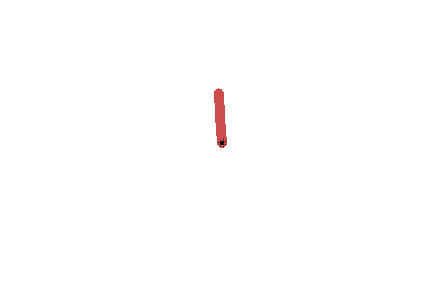
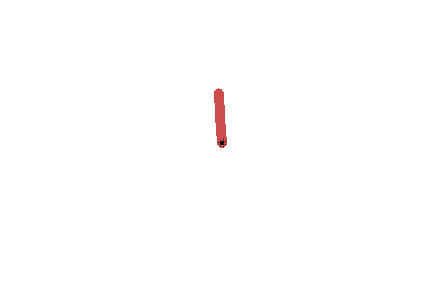
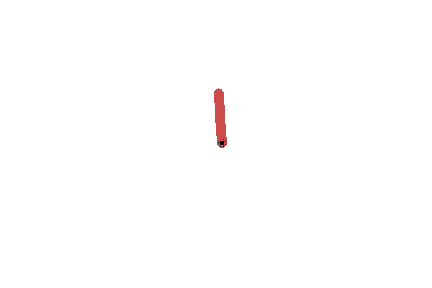
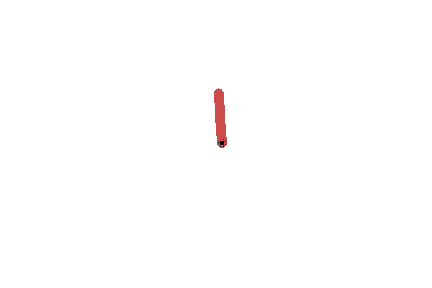
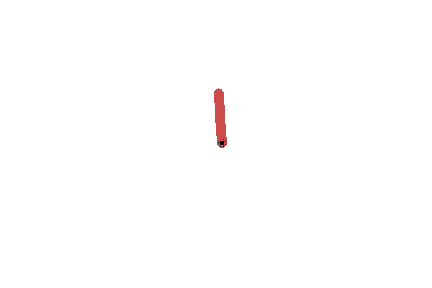
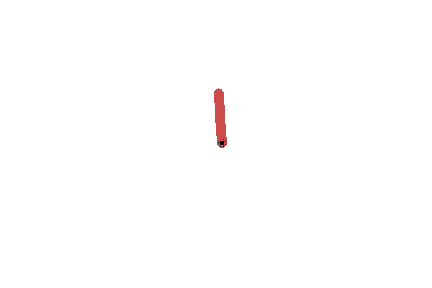
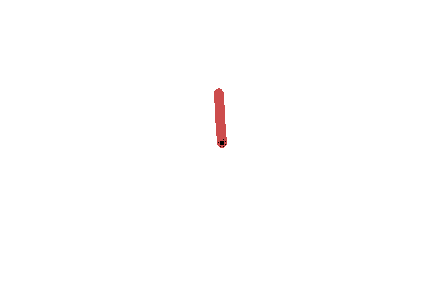
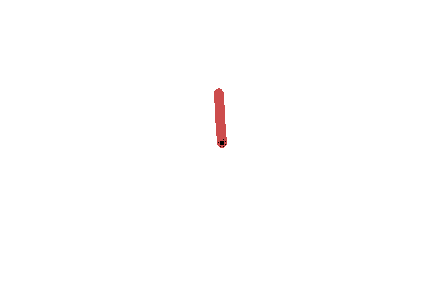
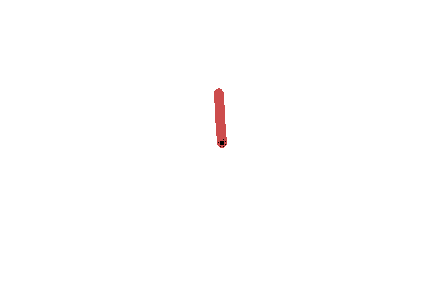
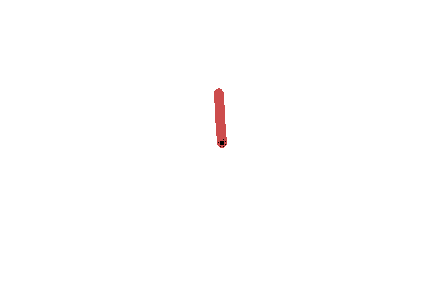
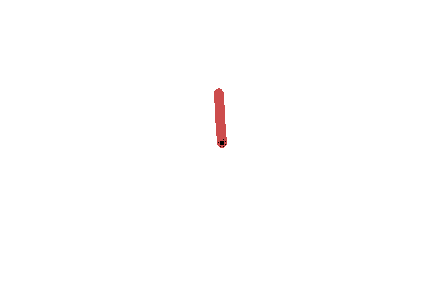
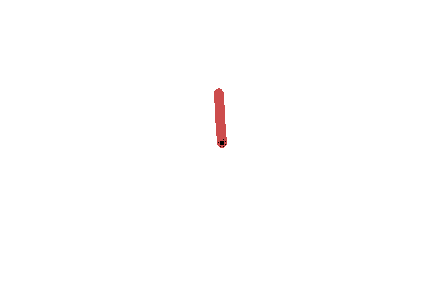
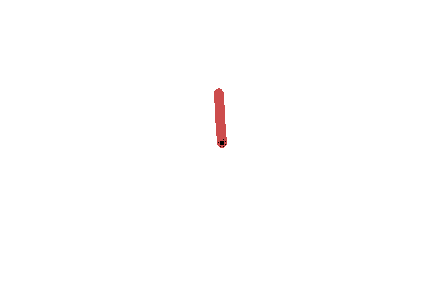
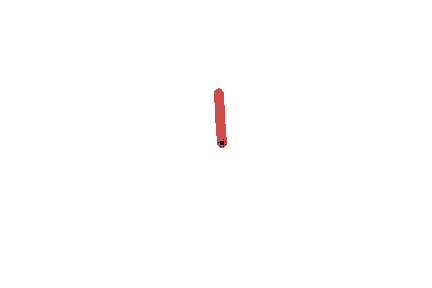
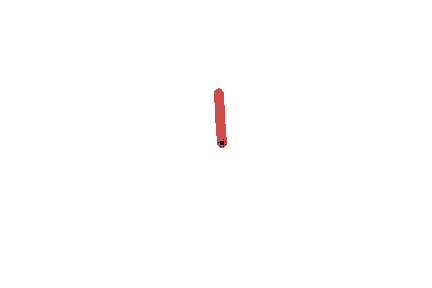
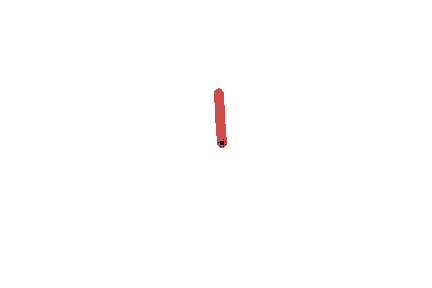
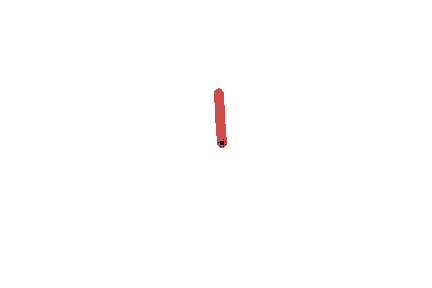
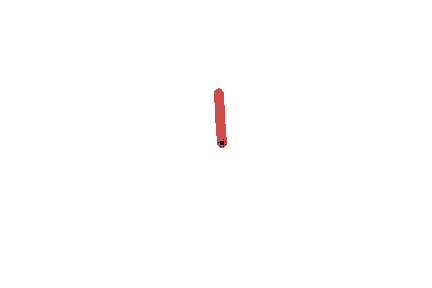
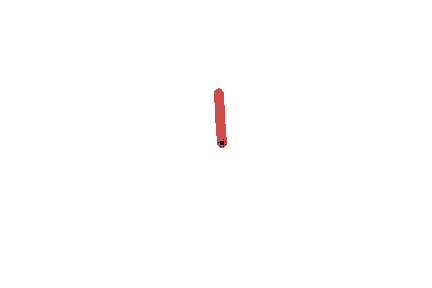
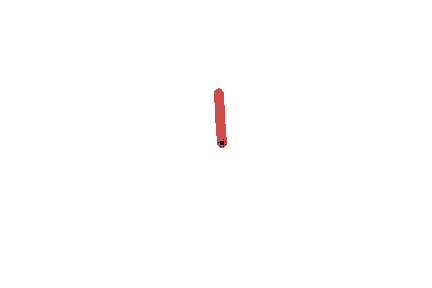
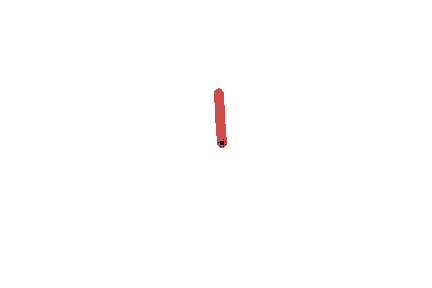
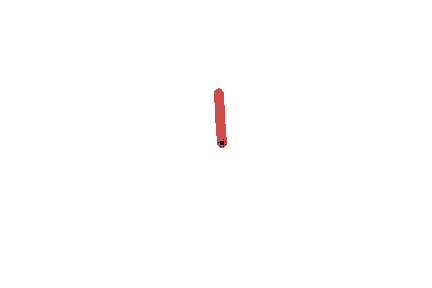
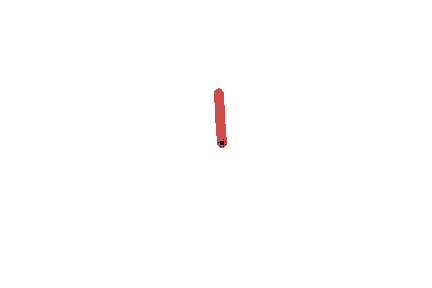
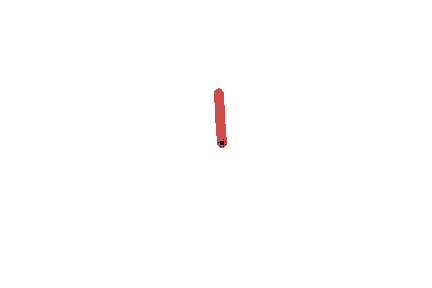
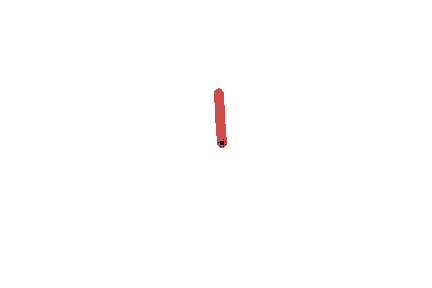
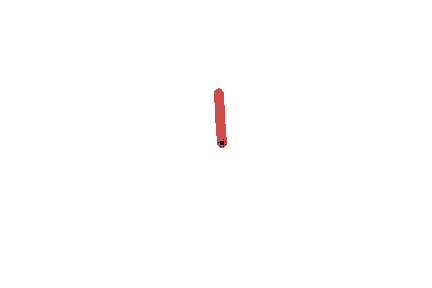
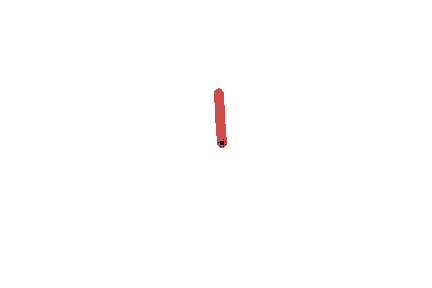
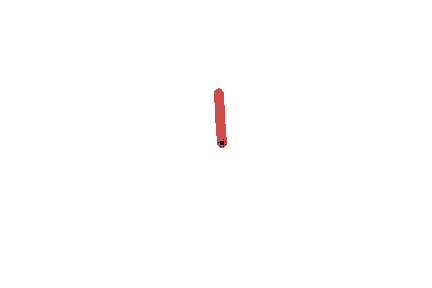
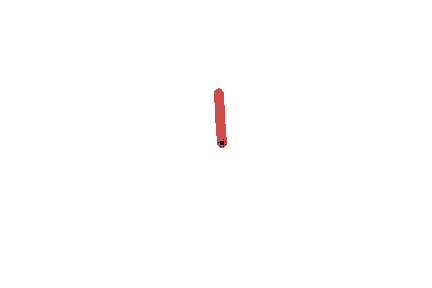
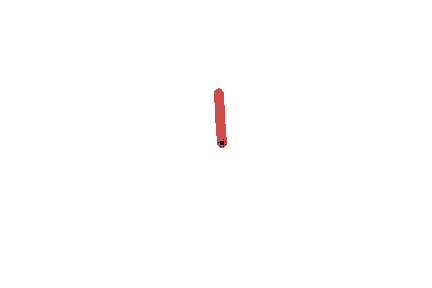
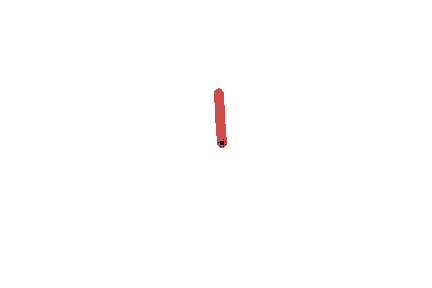
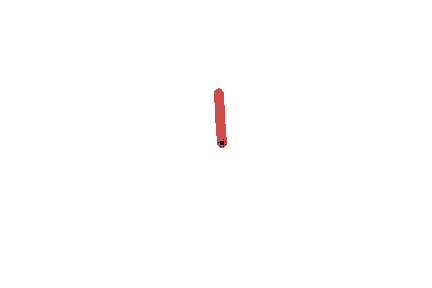
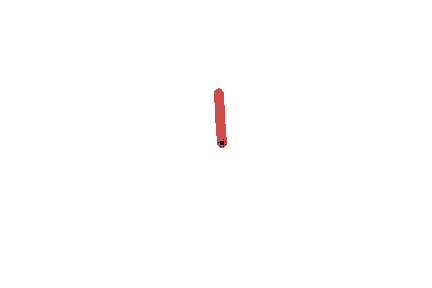
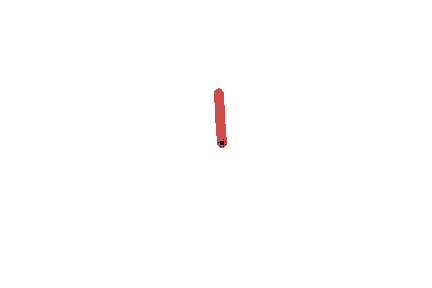
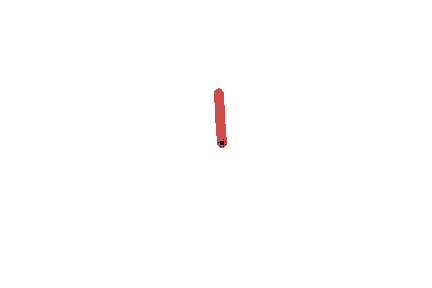
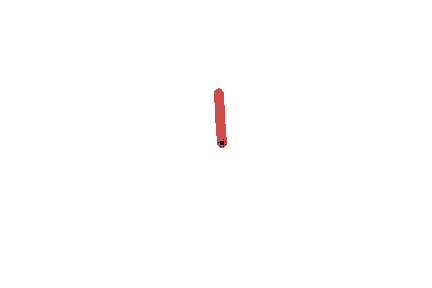
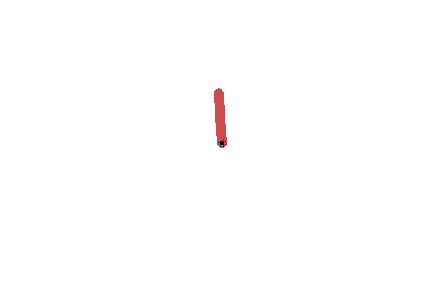
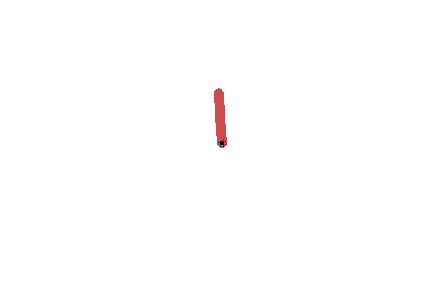
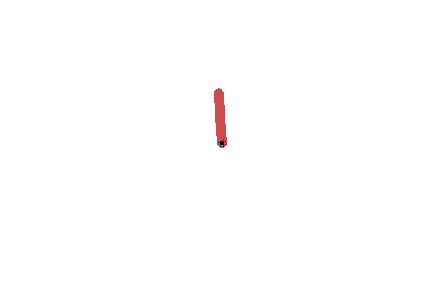
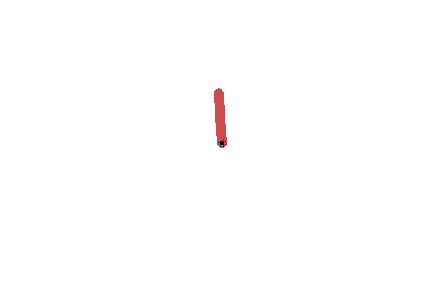
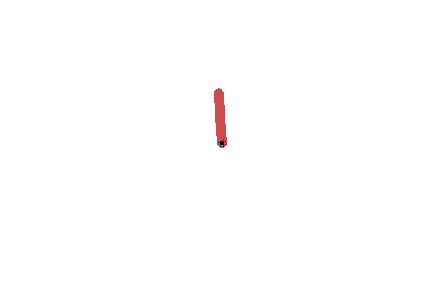
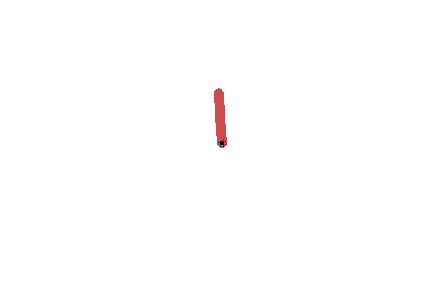
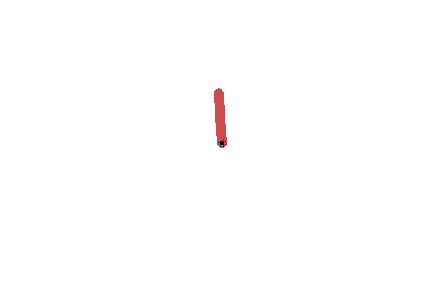
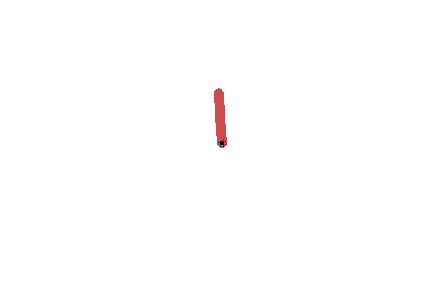
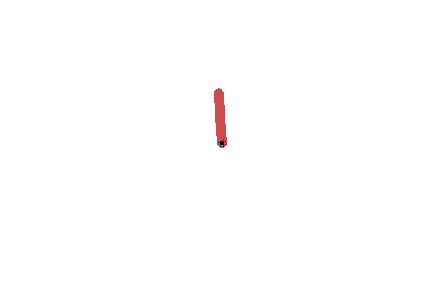
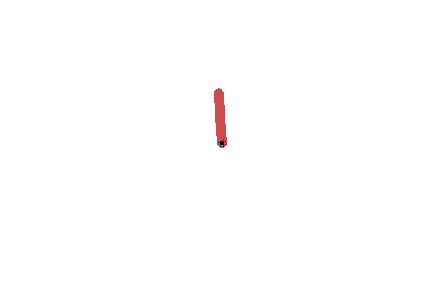
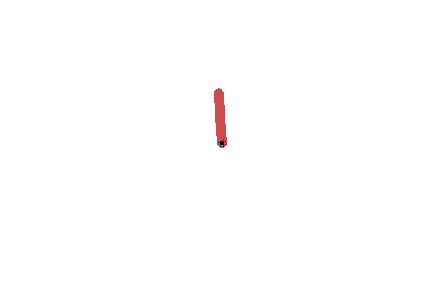
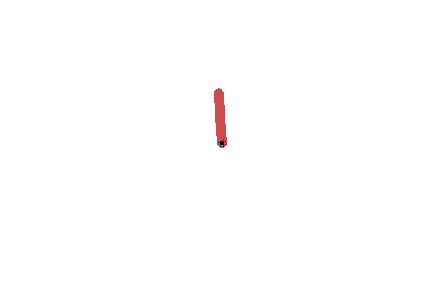
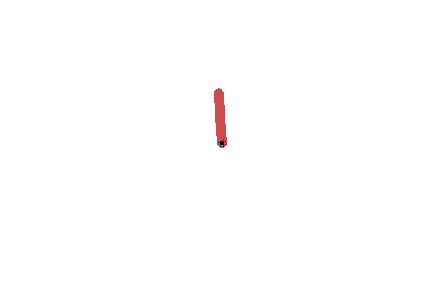
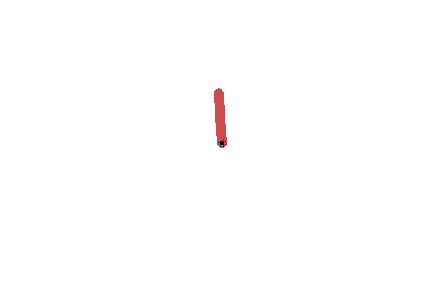
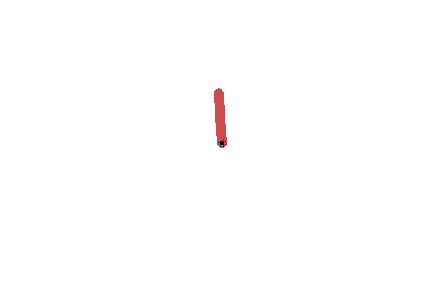
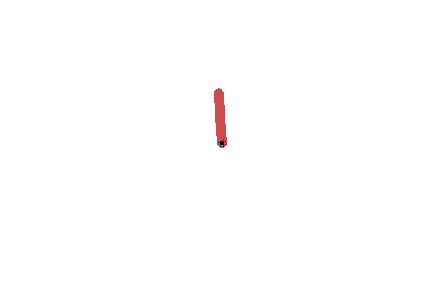
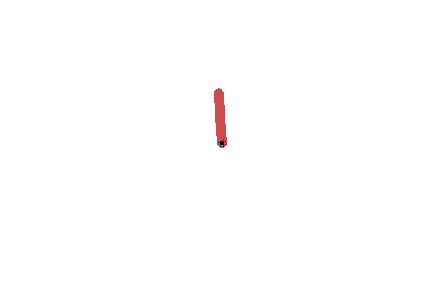
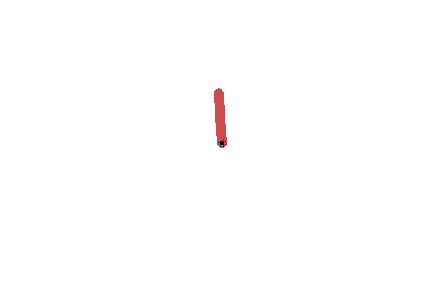
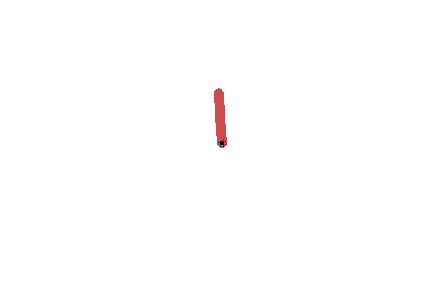
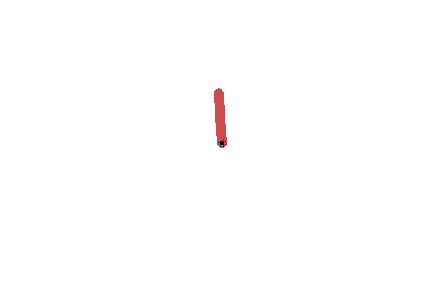
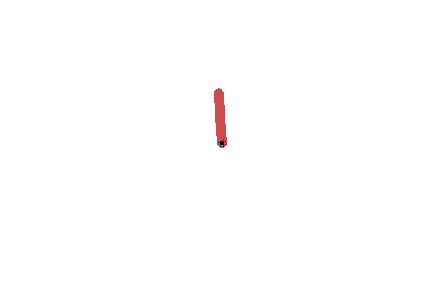
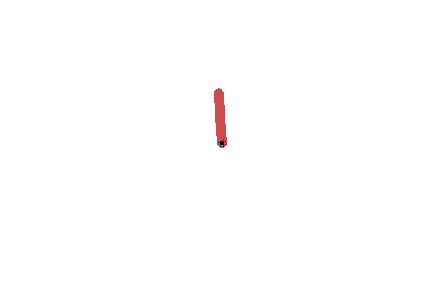
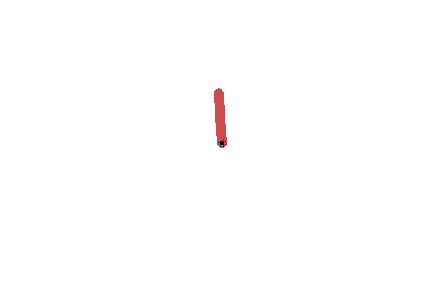
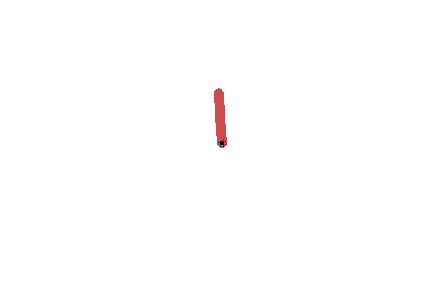
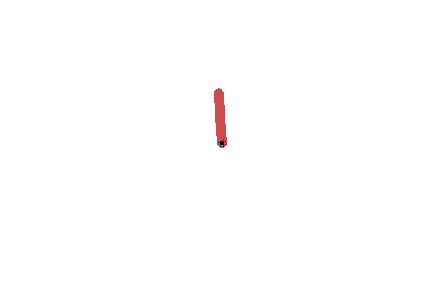
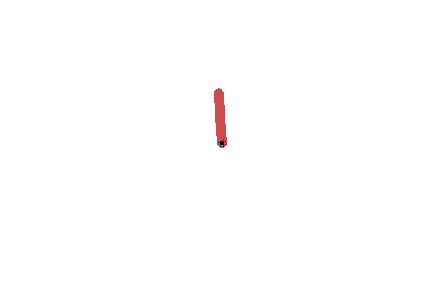
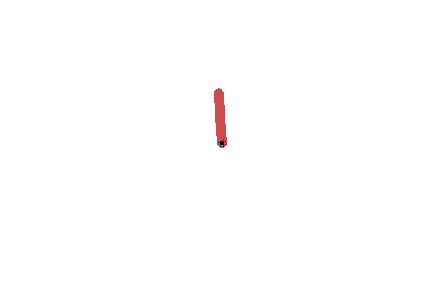
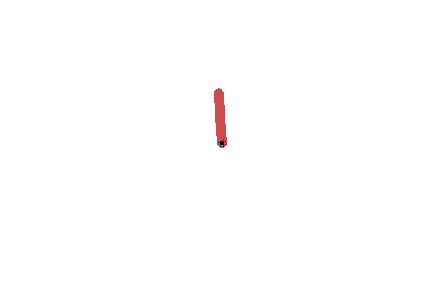
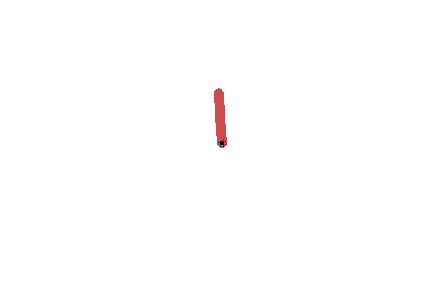
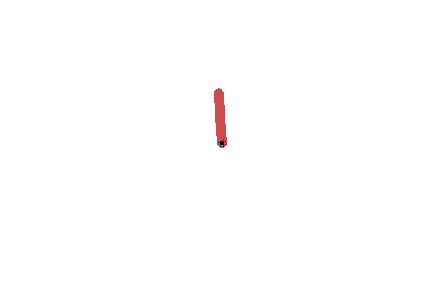
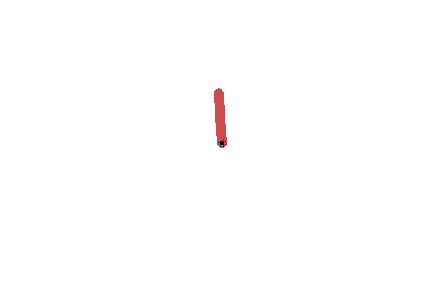
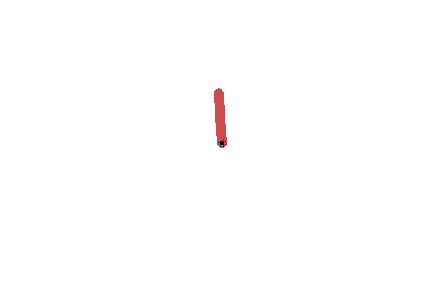
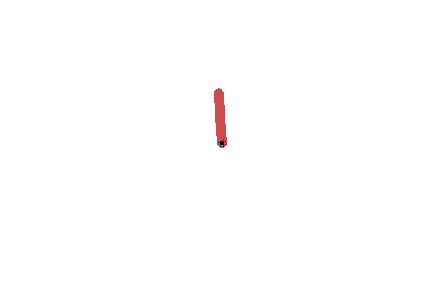
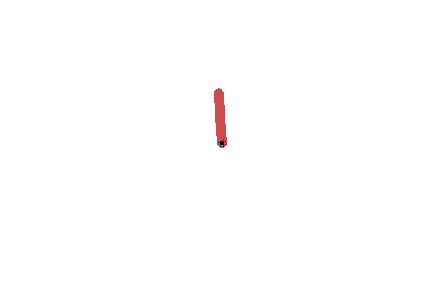
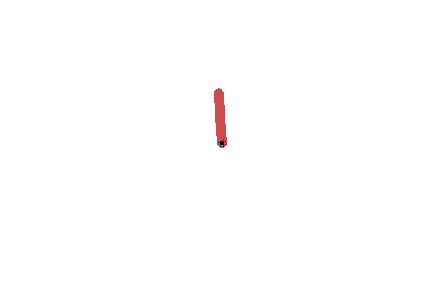
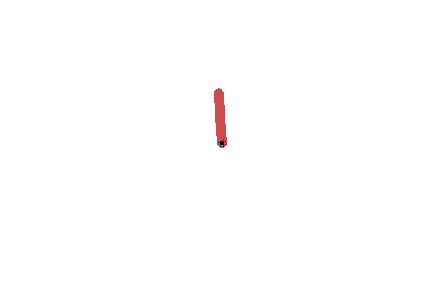
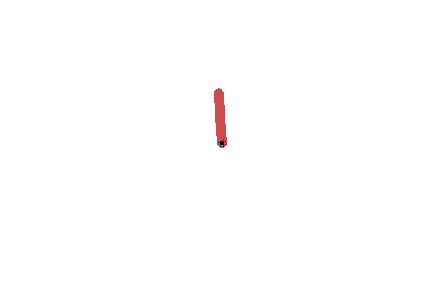
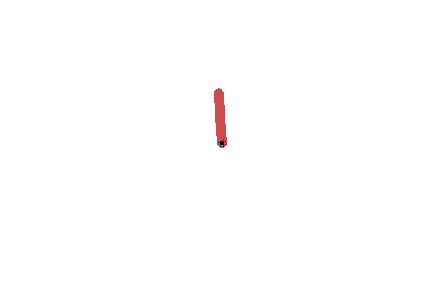
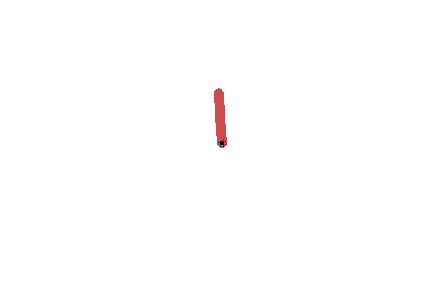
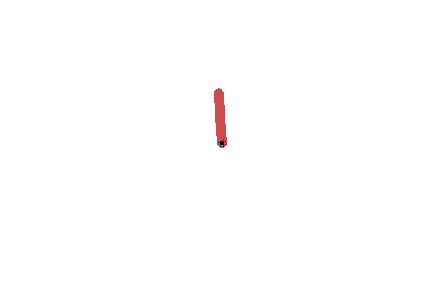
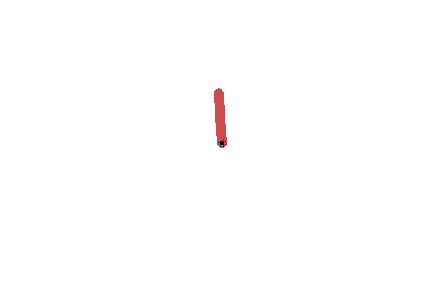
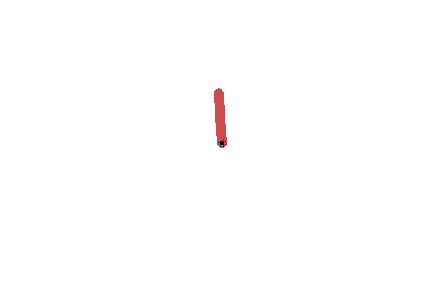
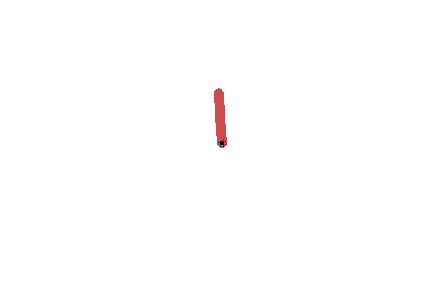
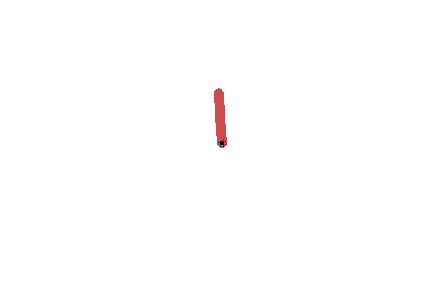
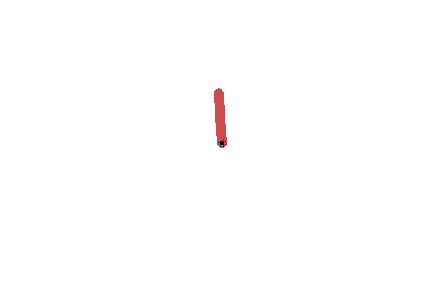
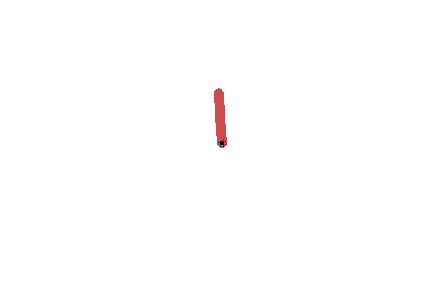
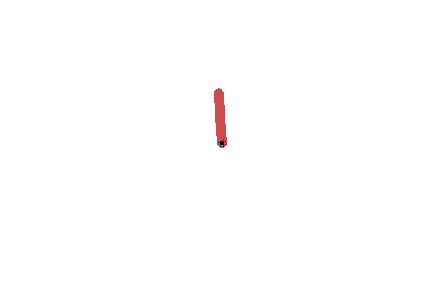
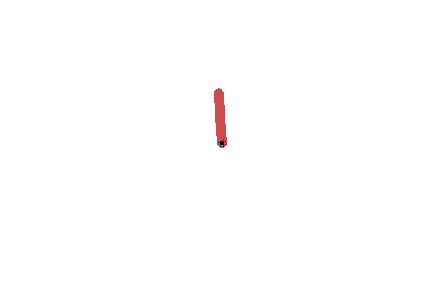
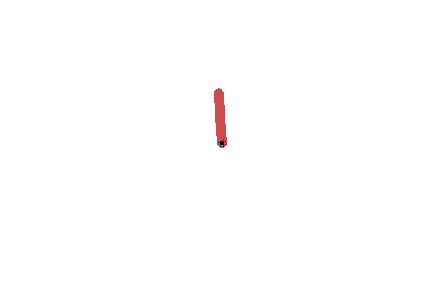
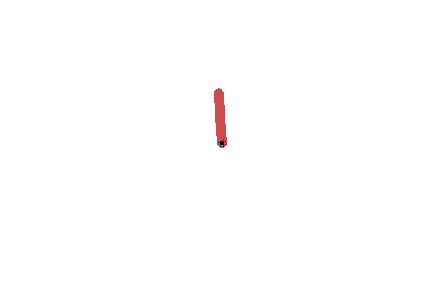
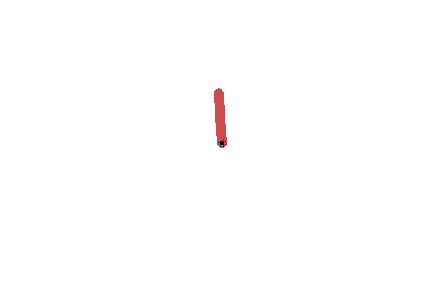
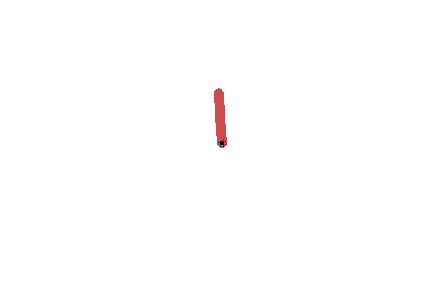
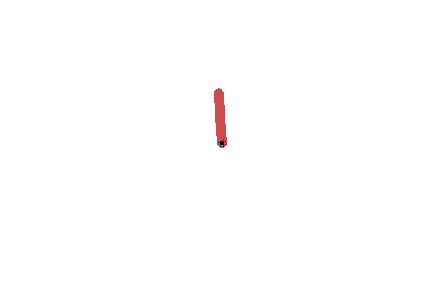
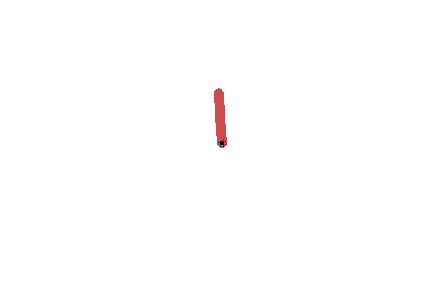

In [ ]:

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))


# display
display_frames_as_gif(frames)